In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/DST_Scoring")

In [ ]:
pip install -U pandas-profiling

In [39]:
from pandas import Series
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.simplefilter('ignore')

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


RANDOM_SEED = 42

In [118]:
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

In [119]:
#размечаем выборку
data_train['Train'] = 1 
data_test['Train'] = 0 
df_def1=df[df['Train']==1]
df_def0=df[df['Train']==0]

In [120]:
#объединяем данные
df = data_train.append(data_test, sort=False).reset_index(drop=True)

In [ ]:
#распределения признаков и корреляции
#распределения части признаков выглядят смещёнными
#сильной корреляции не наблюдается ни для одного из признаков, а значит, они подходят для анализа
#пропуски есть только в столбце education
df[df['Train']==1].profile_report()

In [121]:
#преобразуем столбец дат
df['app_date'] =  pd.to_datetime(df['app_date'])

In [122]:
#все данные за один год, так что значение года не нужно
df['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

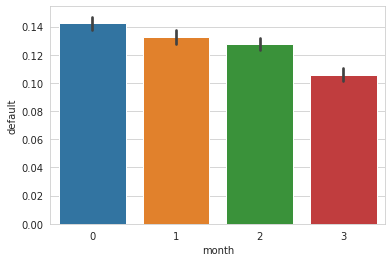

In [123]:
#в выборке представлены данные за 4 месяца, причём значения deafult больше всего отличаются в последнем месяце
sns.barplot(data=df_def1, x=df_def1['month'], y='default')

In [124]:
#создадим отдельные столбцы для дня и месяца
df['month'] = df['app_date'].dt.month
df['day'] = df['app_date'].dt.day
df.drop('app_date',axis=1,inplace=True)

In [125]:
#создадим группы для признаков одного типа
num_cols=['income','bki_request_cnt','age','decline_app_cnt','region_rating','score_bki','day']
bin_cols=['sex','car','car_type','good_work','foreign_passport']
cat_cols=['education','work_address','home_address','sna','first_time','month']

In [126]:
#заполним пропуски в столбце education самым частым значением (исходя из данных profile report)
df.education.fillna('SCH',inplace=True)

In [127]:
#кодируем категориальные и бинарные признаки
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])

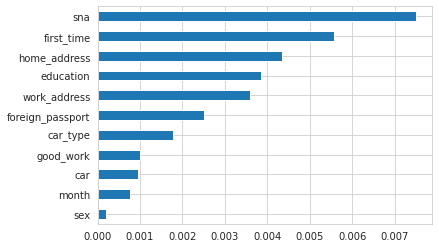

In [128]:
# оценим значимость бинарных  и категориальных признаков
# наибольший вклад у sna и first_time
imp_cat = Series(mutual_info_classif(df_def1[bin_cols + cat_cols], df_def1['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

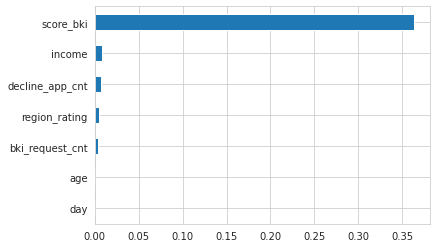

In [129]:
#оценим значимость числовых переменных
#по-видимому, действительно большую роль играет только score_bki
imp_cat2 = Series(mutual_info_classif(df_def1[num_cols], df_def1['default'],
                                     discrete_features =True), index = num_cols)
imp_cat2.sort_values(inplace = True)
imp_cat2.plot(kind = 'barh')

In [130]:
#создаем dummies переменные и стандартизируем числовые признаки
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)
df[num_cols] = StandardScaler().fit_transform(df[num_cols])

In [ ]:
display(df.head(10))

Размечаем выборку для первого варианта модели и обучаем

In [132]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values 
X = train_data.drop(['default'], axis=1)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [134]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [135]:
# очень низкие значения F1 и высокие Accuracy, снова говорят нам о неравномерности выборки
print("Модель 1:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred))

Модель 1: Accuracy(доля правильных ответов): 0.8742 Precision(доля объектов ТР): 0.3661 Recall(доля P из всех найденных Р): 0.0224 F1(среднее гармоническое precision и recall): 0.0423


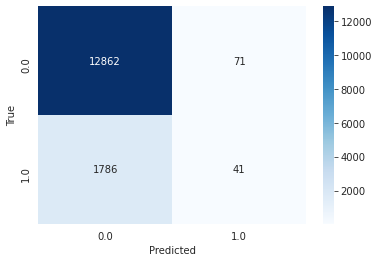

In [136]:
#такое смещение заметно и по матрице ошибок
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,fmt='d', annot=True,cmap='Blues')
plt.show()

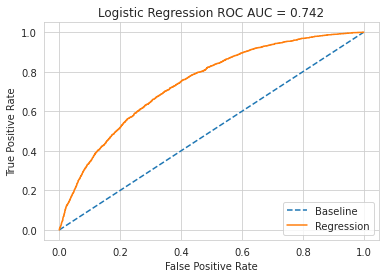

In [137]:
#несмотря на явные проблемы с выборкой, показатель ROC AUC достаточно высокий
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Подбор гиперпараметров для новой модели

In [138]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 5, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 10-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=10, verbose=0)

best_model = clf.fit(X_train, y_train)

#Лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
#метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Лучшее Penalty: l2
Лучшее C: 1.0
Accuracy: 0.8742
Precision: 0.3661
Recall: 0.0224
F1: 0.0423


In [139]:
#обучим модель с новыми параметрами
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True,
                           penalty= 'l2', 
                           solver = 'sag')


model.fit(X_train, y_train)

y_pred_prob2 = model.predict_proba(X_test)[:,1]
y_pred2 = model.predict(X_test)

In [140]:
# сравним модели
# несмотря на падение в Accuracy мы получили значительный прирост параметра F1
print("Модель 1:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred))
print("Модель 2:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred2),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred2),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred2),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred2))

Модель 1: Accuracy(доля правильных ответов): 0.8742 Precision(доля объектов ТР): 0.3661 Recall(доля P из всех найденных Р): 0.0224 F1(среднее гармоническое precision и recall): 0.0423
Модель 2: Accuracy(доля правильных ответов): 0.6730 Precision(доля объектов ТР): 0.2261 Recall(доля P из всех найденных Р): 0.6776 F1(среднее гармоническое precision и recall): 0.3391


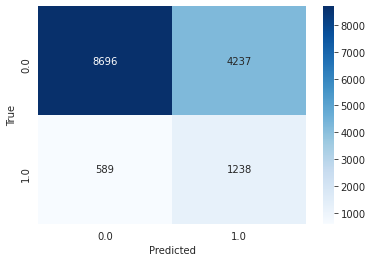

In [141]:
#повышение качества модели заметно и на матрице ошибок: точность определения упала, но выросла доля True Positive оценок
confusion_matrix2 = pd.crosstab(y_test, y_pred2, rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix2,fmt='d', annot=True,cmap='Blues')
plt.show()

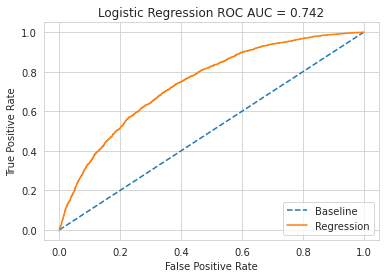

In [143]:
#показатель ROC AUC сохранился на прежнем уровне
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob2)
roc_auc = roc_auc_score(y_test, y_pred_prob2)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [145]:
#используем обучение модели с penalty l1, чтобы оценить важность каждого из признаков для модели
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True,
                           penalty= 'l1', 
                           solver = 'liblinear')


model.fit(X_train, y_train)

y_pred_prob2 = model.predict_proba(X_test)[:,1]
y_pred2 = model.predict(X_test)

log_odds = model.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
score_bki,0.486973
home_address_1,0.399716
sex,0.280200
bki_request_cnt,0.172219
sna_3,0.166700
education_3,0.161929
decline_app_cnt,0.132278
first_time_1,0.077835
month_0,0.072134
education_4,0.010020


In [146]:
#список признаков, не оказывающих влияния на модель
drop_cols = ['month_1', 'first_time_0', 'sna_1']

In [147]:
#заново формируем выборки для обучения без этих признаков
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_cols, axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [148]:
#третий вариант модели
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True,
                           penalty= 'l2', 
                           solver = 'sag')


model.fit(X_train, y_train)

y_pred_prob3 = model.predict_proba(X_test)[:,1]
y_pred3 = model.predict(X_test)

In [150]:
# к сожалению, отличия парметров, матрицы ошибок и ROC AUC от второй модели минимальны, остановимся на второй модели
print("Модель 1:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred))
print("Модель 2:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred2),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred2),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred2),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred2))
print("Модель 3:", 'Accuracy(доля правильных ответов): %.4f' % accuracy_score(y_test, y_pred3),
      'Precision(доля объектов ТР): %.4f' % precision_score(y_test, y_pred3),
      'Recall(доля P из всех найденных Р): %.4f' % recall_score(y_test, y_pred3),
      'F1(среднее гармоническое precision и recall): %.4f' % f1_score(y_test, y_pred3))

Модель 1: Accuracy(доля правильных ответов): 0.8742 Precision(доля объектов ТР): 0.3661 Recall(доля P из всех найденных Р): 0.0224 F1(среднее гармоническое precision и recall): 0.0423
Модель 2: Accuracy(доля правильных ответов): 0.6730 Precision(доля объектов ТР): 0.2260 Recall(доля P из всех найденных Р): 0.6771 F1(среднее гармоническое precision и recall): 0.3389
Модель 3: Accuracy(доля правильных ответов): 0.6730 Precision(доля объектов ТР): 0.2261 Recall(доля P из всех найденных Р): 0.6776 F1(среднее гармоническое precision и recall): 0.3391


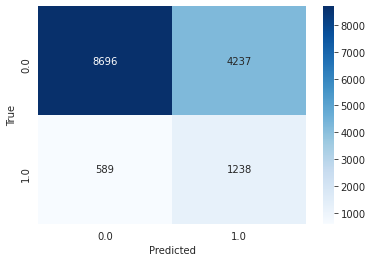

In [152]:
confusion_matrix3 = pd.crosstab(y_test, y_pred3, rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix3,fmt='d', annot=True,cmap='Blues')
plt.show()

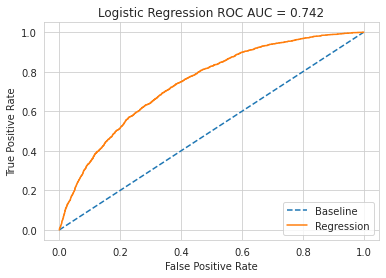

In [153]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob3)
roc_auc = roc_auc_score(y_test, y_pred_prob3)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Финальная модель и формирование файла с искомыми признаками

In [154]:
train_data = df.query('Train == 1').drop(['Train', 'client_id']+drop_cols, axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id']+drop_cols, axis=1)

In [155]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [ ]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True,
                           penalty= 'l2', 
                           solver = 'sag')


model.fit(X_train, y_train)

In [157]:
y_pred_prob = model.predict_proba(X_test)[:,1]


final = pd.DataFrame(data_test.client_id)
final['default']=y_pred_prob
final.to_csv('submission.csv', index=False)

In [158]:
final

,client_id,default
0,74835,0.211396
1,17527,0.796644
2,75683,0.323698
3,26883,0.408235
4,28862,0.166081
...,...,...
36344,83775,0.767348
36345,106254,0.084806
36346,81852,0.788298
36347,1971,0.602149
